In [1]:
# Import packages
#%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.basics import *
from fastai.vision.all import *
import torch

from matplotlib.colors import LogNorm

# Visualizes all the columns
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, append=True)
#from sklearn.utils.testing import ignore_warnings
#from sklearn.exceptions import ConvergenceWarning

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print(torch.cuda.is_available())

True


In [4]:
import torch
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.2.0.dev20231002+cu118
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Jul_11_03:10:21_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.2, V12.2.128
Build cuda_12.2.r12.2/compiler.33053471_0
**********
CUDNN version: 8700
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


# prelim data analysis

In [5]:
df = pd.read_csv(f"C:/Users/brian/Documents/Research/galaxies/testing_small.csv", dtype={'objID': str}).rename({'oh_p50': 'metallicity'}, axis=1)
df[['objID', 'ra', 'dec', 'metallicity']].sample(5)

,objID,ra,dec,metallicity
464,1237648722289819869,146.530885,0.781935,8.109317
488,1237648722289361169,145.541171,0.795448,8.993473
178,1237656528382263368,260.124682,59.166551,8.723758
292,1237650369941799076,172.554009,-2.935433,8.954901
124,1237651211213013238,255.538073,59.303383,8.828976


In [7]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['objID'], pref=f'C:/Users/brian/Documents/Research/galaxies/images/', suff='.jpg'),
    get_y=ColReader(['metallicity']),
    splitter=RandomSplitter(0.2),
    item_tfms=[CropPad(64), RandomCrop(56)],
    batch_tfms=[Normalize],
)

In [10]:
dls = ImageDataLoaders.from_dblock(dblock, df, path='C:/Users/brian/Documents/Research/galaxies/images/', bs=128)

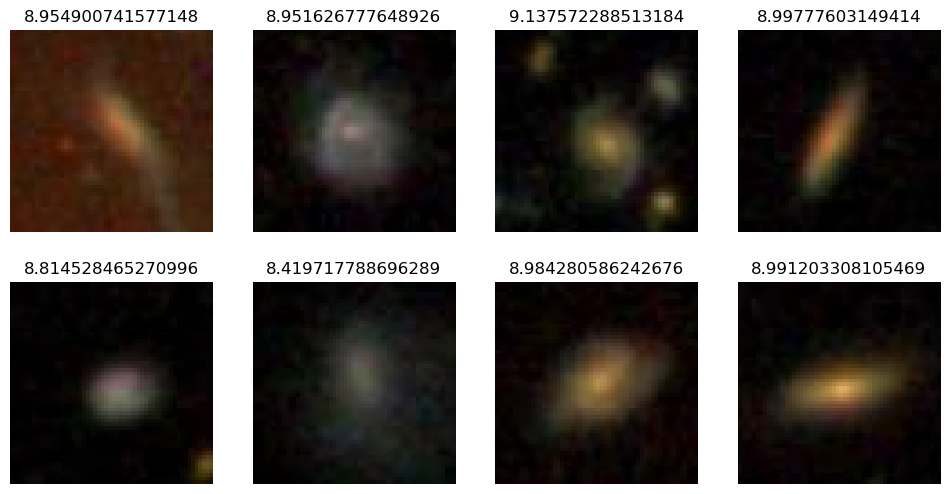

In [11]:
dls.show_batch(nrows = 2, ncols = 4)

In [12]:
valid_ds = dls.valid_ds

# Extract the validation data items (file paths)
validation_data = valid_ds.items

validation_data.head()

,objID,specObjID,ra,dec,metallicity
311,1237671129124110556,368197895326820352,174.143116,-2.989591,9.092210
11,1237663783660683462,435763701048436736,0.398885,-0.395180,9.063031
413,1237663543697211498,437000651663239168,2.750729,0.309261,9.027649
100,1237657191979286713,435889045374003200,0.822374,0.789815,8.970663
118,1237651224634851384,397517187599853568,256.048920,59.243693,8.932321


In [13]:
def root_mean_squared_error(p, y): 
    return torch.sqrt(F.mse_loss(p.view(-1), y.view(-1)))

# runner functions

In [14]:
def find_lr(model):
    learn = Learner(
        dls, 
        model,
        opt_func = ranger,
        loss_func = root_mean_squared_error
    )
    
    lr = learn.lr_find()
    
    print(lr)

In [15]:
def test_model(model, lr, epoch, df, name):
    learn = Learner(
        dls, 
        model,
        opt_func = ranger,
        loss_func = root_mean_squared_error
    )
    
    learn.fit_one_cycle(epoch, lr)
    
    learn.recorder.plot_loss()
    plt.ylim(0, 1);
    
    preds, trues = learn.tta()
    preds = to_np(preds.view(-1))
    trues = to_np(trues.view(-1))
    
    result_df = pd.DataFrame({
        'objID' : validation_data['objID'], 
        'metallicity' : validation_data['metallicity'],
        'predicted_metallicity' : preds.squeeze(),
    })
    
    result_df.to_csv('C:/Users/brian/Documents/Research/galaxies/{}.csv'.format(name), index = False)
    
    show_results(preds, trues)

In [16]:
def show_results(preds, trues):
    plt.figure(figsize=(4, 4), dpi=150)

    ax = plt.axes()
    ax.set_facecolor("gainsboro")

    plt.hist2d(trues, preds, bins=50, range=[(7.5, 9.5), (7.5, 9.5)], cmap='Blues')

    plt.xlim(7.5, 9.5)
    plt.ylim(7.5, 9.5)
    plt.gca().set_aspect('equal')

    plt.text(8, 7, f'RMSE = {np.mean((preds-trues)**2)**0.5:.4f} dex', fontsize=12)

    plt.xticks(np.arange(7.5, 9.75, 0.25))
    plt.yticks(np.arange(7.5, 9.75, 0.25))

    plt.grid(color = "white")
    plt.gca().set_axisbelow(True)

    plt.xlabel(r'$Z_{\rm true}$', fontsize=12)
    plt.ylabel(r'$Z_{\rm pred}$', fontsize=12)

# testing stuff

## CNN based on VG-16, why is this the best one lmao

In [18]:
model = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3,20,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(20,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*14*14, 4096),
            nn.ReLU(),
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128,1)            
)

In [ ]:
find_lr(model)

epoch,train_loss,valid_loss,time
0,8.974562,8.980365,00:01
1,8.973455,8.978576,00:01


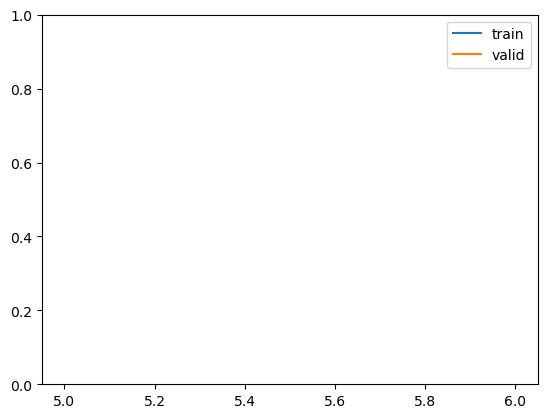

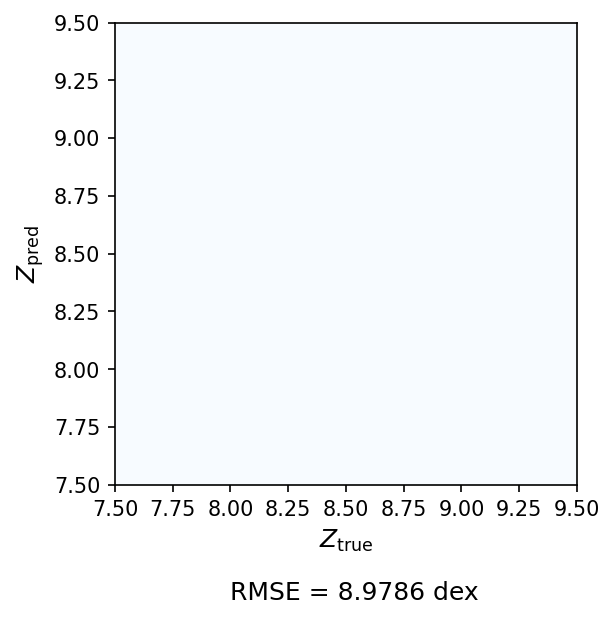

In [20]:
test_model(model, 0.0002754228771664202, 2, df,"biswadev")

AttributeError: 'DataFrame' object has no attribute 'prediction'

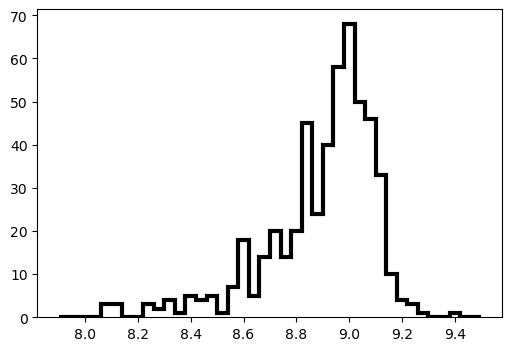

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

bins = 40
histrange_true = [7.9, 9.5]
histrange_pred = [7.9, 9.5]

ax.hist(df.metallicity, bins=bins, range=histrange_true, color='k', histtype='step', lw=3, label=r'$Z_{\rm true}$');
ax.hist(df.prediction, bins=bins, range=histrange_pred, color=c_median, histtype='step', lw=3, ls='-', label=r'$Z_{\rm pred}$')

ax.legend(fontsize=16, loc='upper left', frameon=False)

fig.subplots_adjust(left=0.175, bottom=0.175, right=0.95, top=0.95)

ax.tick_params(labelsize=14)
ax.set_xlabel('Metallicity', fontsize=18)
ax.set_ylabel('Number of galaxies', fontsize=18);


## what about less linear layers lmao

In [13]:
import torch.nn as nn

class InceptionRes(nn.Module):
    def __init__(self):
        super(InceptionRes, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(2),
            nn.Conv2d(64, 64, 5),
            nn.ReLU()
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out3 = self.conv3(x)
        out5 = self.conv5(x)
        return torch.cat([out1, out3, out5, x], dim=1)

model = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3,64,3),
            nn.ReLU(),
            InceptionRes(),
            nn.Conv2d(256,64,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            InceptionRes(),
            nn.Conv2d(256,64,1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*14*14, 4096),
            nn.ReLU(),
            nn.Linear(4096,1)          
)

find_lr(model)

KeyboardInterrupt: 

epoch,train_loss,valid_loss,time
0,0.463678,0.199505,38:52
1,0.508877,0.611557,35:09
2,0.204522,0.180960,34:53
3,0.183911,0.145275,34:43
4,0.162029,0.134531,34:54
5,0.145205,0.128561,34:55
6,0.136873,0.137762,34:56
7,0.126944,0.119126,34:55
8,0.120641,0.119953,34:54
9,0.118742,0.118617,34:52


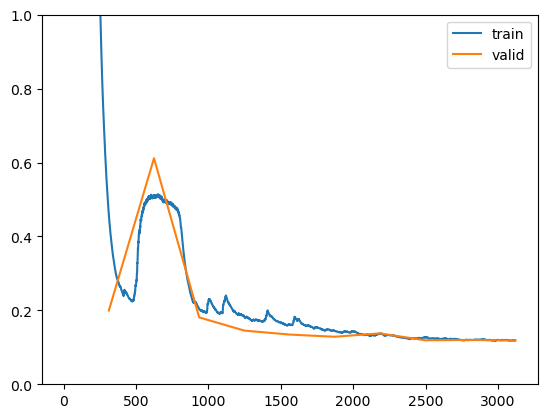

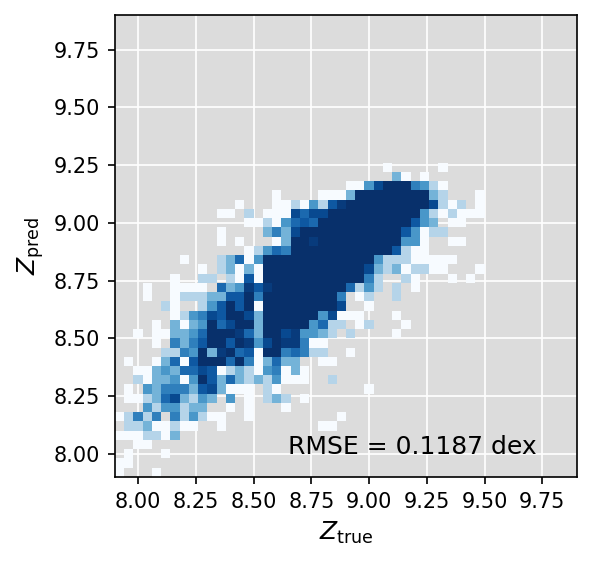

In [14]:
test_model(model, 0.0003311311302240938, 10)

## idk maybe some other stuff will work

SuggestedLRs(valley=0.0003981071640737355)


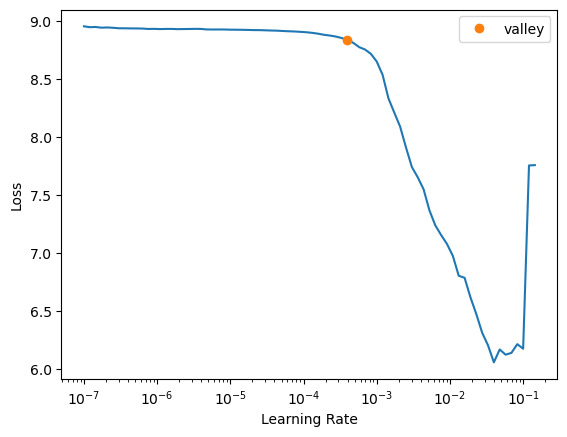

In [16]:
import torch.nn as nn

class Inception(nn.Module):
    def __init__(self):
        super(Inception, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(2),
            nn.Conv2d(64, 64, 5),
            nn.ReLU()
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out3 = self.conv3(x)
        out5 = self.conv5(x)
        return torch.cat([out1, out3, out5], dim=1)

model = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3,64,3),
            nn.ReLU(),
            Inception(),
            nn.Conv2d(192,64,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            Inception(),
            nn.Conv2d(192,64,1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*12*12, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1)
)

find_lr(model)

epoch,train_loss,valid_loss,time
0,8.564563,7.557935,06:10
1,2.780190,0.201897,06:11
2,0.913527,0.208797,06:08
3,0.447483,0.280616,06:08
4,0.288213,0.155217,06:29
5,0.214387,0.147370,06:17
6,0.165072,0.137973,06:17
7,0.143965,0.136081,06:17
8,0.135232,0.131881,06:22
9,0.131335,0.132725,06:11


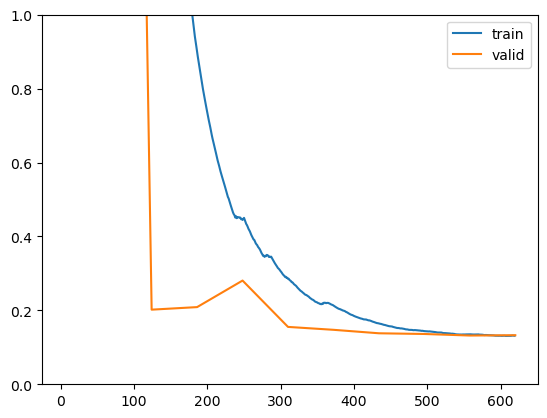

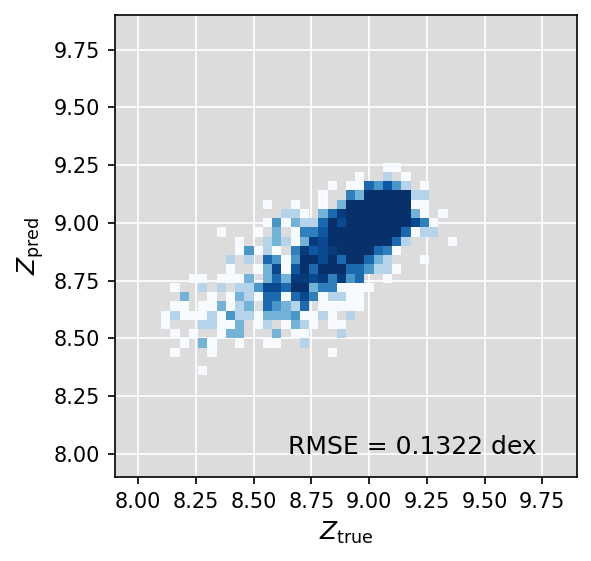

In [17]:
test_model(model, 0.0003981071640737355, 10)

## what about less linear layers but without res as well

SuggestedLRs(valley=0.0002290867705596611)


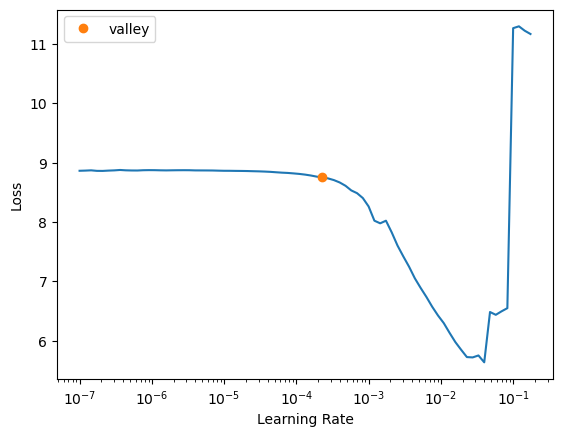

In [18]:
import torch.nn as nn

class Inception(nn.Module):
    def __init__(self):
        super(Inception, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(2),
            nn.Conv2d(64, 64, 5),
            nn.ReLU()
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out3 = self.conv3(x)
        out5 = self.conv5(x)
        return torch.cat([out1, out3, out5], dim=1)

model = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3,64,3),
            nn.ReLU(),
            Inception(),
            nn.Conv2d(192,64,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            Inception(),
            nn.Conv2d(192,64,1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*14*14, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1)
)

find_lr(model)

epoch,train_loss,valid_loss,time
0,0.672652,0.209935,33:58
1,0.200111,0.160797,35:27
2,0.193002,0.152180,34:55
3,0.189715,0.214861,34:23
4,0.164863,0.149738,22:01
5,0.160185,0.138467,18:55
6,0.141912,0.138679,18:55
7,0.136455,0.141179,18:55
8,0.129764,0.129752,18:54
9,0.128735,0.129411,18:54


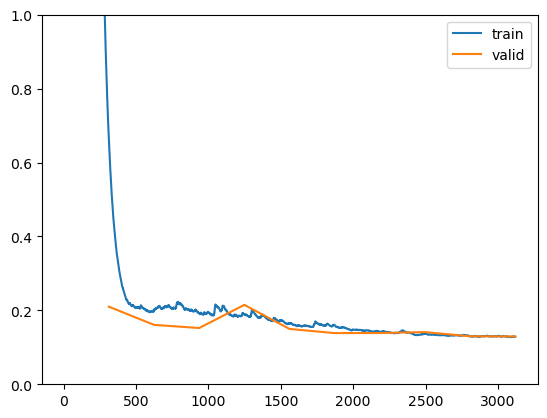

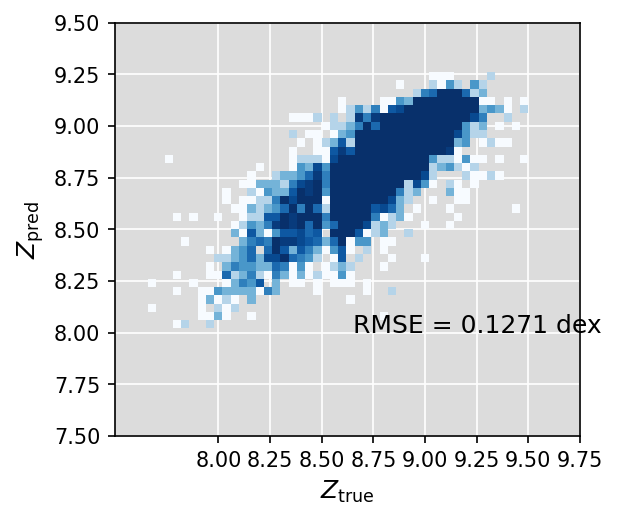

In [19]:
test_model(model, 0.0002290867705596611, 10)

## maybe more linear layers will do something

SuggestedLRs(valley=0.0004786300996784121)


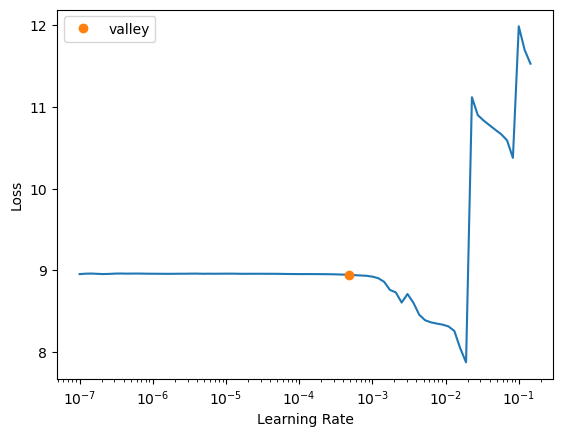

In [18]:
import torch.nn as nn

class InceptionRes(nn.Module):
    def __init__(self):
        super(InceptionRes, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(2),
            nn.Conv2d(64, 64, 5),
            nn.ReLU()
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out3 = self.conv3(x)
        out5 = self.conv5(x)
        return torch.cat([out1, out3, out5, x], dim=1)

model = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3,64,3),
            nn.ReLU(),
            InceptionRes(),
            nn.Conv2d(256,64,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            InceptionRes(),
            nn.Conv2d(256,64,1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*14*14, 4096),
            nn.ReLU(),
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,1)          
)

find_lr(model)

epoch,train_loss,valid_loss,time
0,8.892281,8.636068,08:14
1,3.470834,1.136442,07:07
2,1.636627,0.408592,06:58
3,0.800427,0.226184,06:59
4,0.398029,0.163467,07:13
5,0.254345,0.161886,07:06
6,0.195879,0.154343,06:59
7,0.166208,0.152247,07:14
8,0.155004,0.151428,07:09
9,0.149833,0.149955,07:10


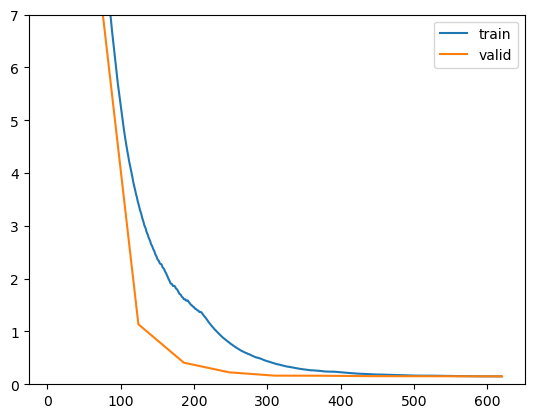

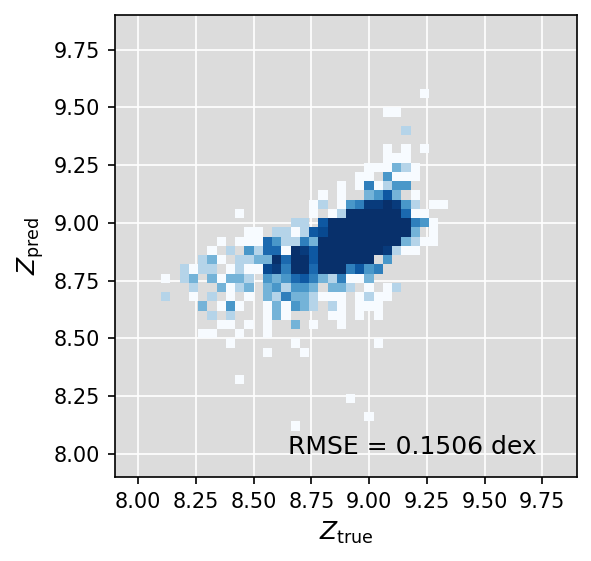

In [19]:
test_model(model, 0.0004786300996784121, 10)

## vg16 pt3

SuggestedLRs(valley=0.0004786300996784121)


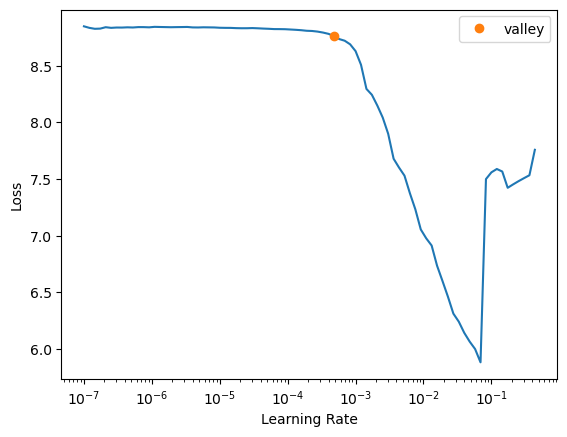

In [14]:
import torch.nn as nn

class InceptionRes(nn.Module):
    def __init__(self):
        super(InceptionRes, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(2),
            nn.Conv2d(64, 64, 5),
            nn.ReLU()
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out3 = self.conv3(x)
        out5 = self.conv5(x)
        return torch.cat([out1, out3, out5, x], dim=1)

model = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3,64,3),
            nn.ReLU(),
            InceptionRes(),
            nn.Conv2d(256,64,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            InceptionRes(),
            nn.Conv2d(256,64,1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*14*14, 4096),
            nn.ReLU(),
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128,1)          
)

find_lr(model)

epoch,train_loss,valid_loss,time
0,0.489535,0.294965,38:05
1,0.283128,0.290417,37:34
2,0.247169,0.245307,37:39
3,0.204110,0.147362,37:41
4,0.202738,0.173403,37:55
5,0.150460,0.125512,37:09
6,0.133057,0.121377,36:38
7,0.127279,0.121322,36:33
8,0.118916,0.117973,36:34
9,0.119058,0.117511,36:34


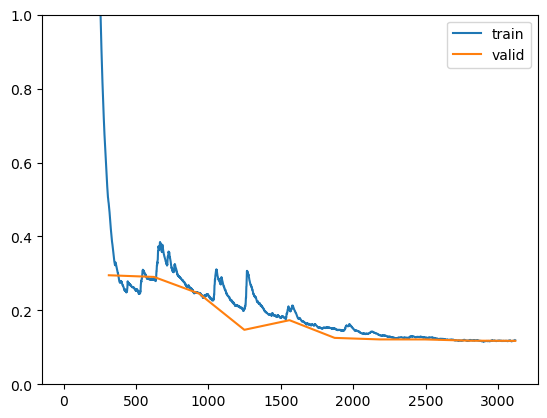

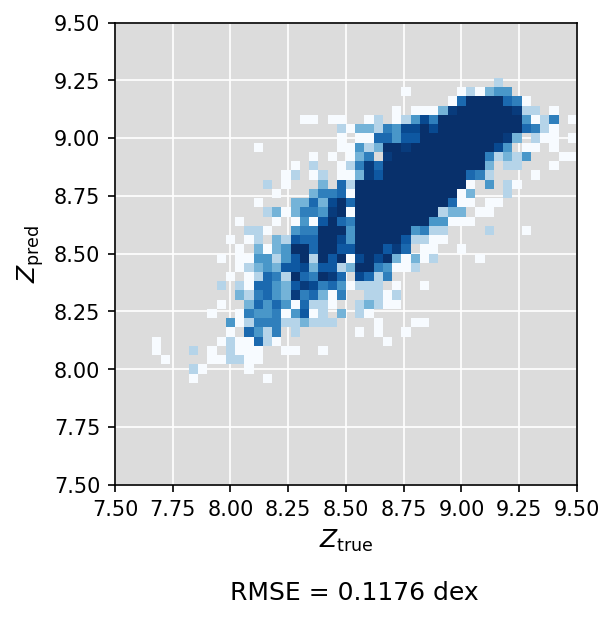

In [15]:
test_model(model, 0.0004786300996784121, 10)

## xresnet copy?

SuggestedLRs(valley=0.0002754228771664202)


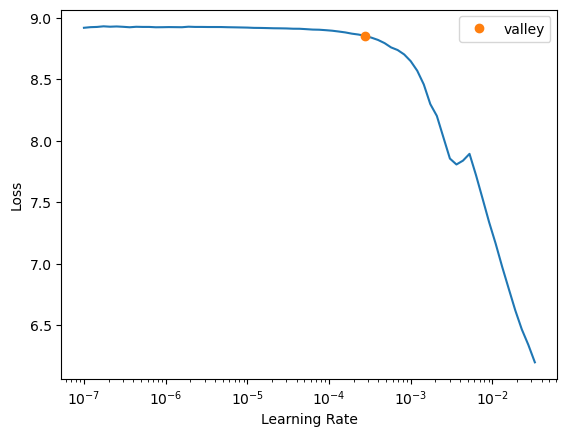

In [17]:
class ResNetConv(nn.Module):
    def __init__(self):
        super(ResNetConv, self).__init__()
        
        self.dir = nn.Sequential(
            nn.Conv2d(64,64,1),
            nn.ReLU()
        )
        
        self.conv = nn.Sequential(
            nn.Conv2d(64,64,1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.Conv2d(64,64,1),
            nn.ReLU()
        )
        
    def forward(self, x):
        outDir = self.dir(x)
        outConv = self.conv(x)
        return torch.cat([outDir, outConv], dim=1)
    
class ResNetIdentity(nn.Module):
    def __init__(self):
        super(ResNetIdentity, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(64,64,1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.Conv2d(64,64,1),
            nn.ReLU()
        )
    
    def forward(self, x):
        outConv = self.conv(x)
        return torch.cat([x, outConv], dim=1)

model = nn.Sequential(
            nn.Conv2d(3,64,1),
            nn.ReflectionPad2d(3),
            nn.Conv2d(64,64,7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResNetConv(),
            nn.Conv2d(128,64,1),
            ResNetIdentity(),
            nn.Conv2d(128,64,1),
            ResNetIdentity(),
            nn.Conv2d(128,64,1),
            ResNetConv(),
            nn.Conv2d(128,64,1),
            ResNetIdentity(),
            nn.Conv2d(128,64,1),
            ResNetIdentity(),
            nn.Conv2d(128,64,1),
            ResNetIdentity(),
            nn.Conv2d(128,64,1),
            ResNetConv(),
            nn.Conv2d(128,64,1),
            ResNetIdentity(),
            nn.Conv2d(128,64,1),
            ResNetIdentity(),
            nn.Conv2d(128,64,1),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*14*14,128),
            nn.ReLU(),
            nn.Linear(128,1)
)

find_lr(model)

epoch,train_loss,valid_loss,time
0,8.687211,8.232761,01:19
1,4.325968,0.192916,01:17
2,1.308144,0.186871,01:19
3,0.503924,0.172561,01:18
4,0.266284,0.154482,01:17
5,0.196590,0.153452,01:18
6,0.171868,0.154408,01:18
7,0.161314,0.148513,01:19
8,0.158056,0.148017,01:21
9,0.156550,0.148305,01:21


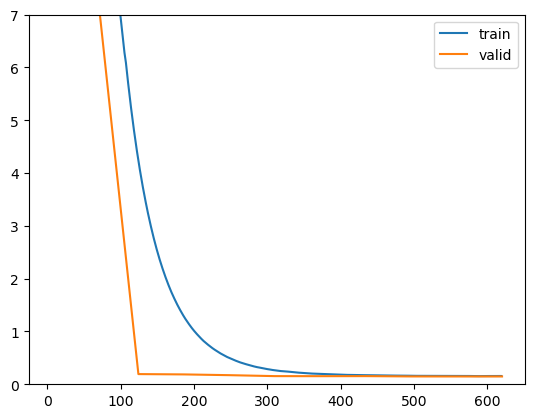

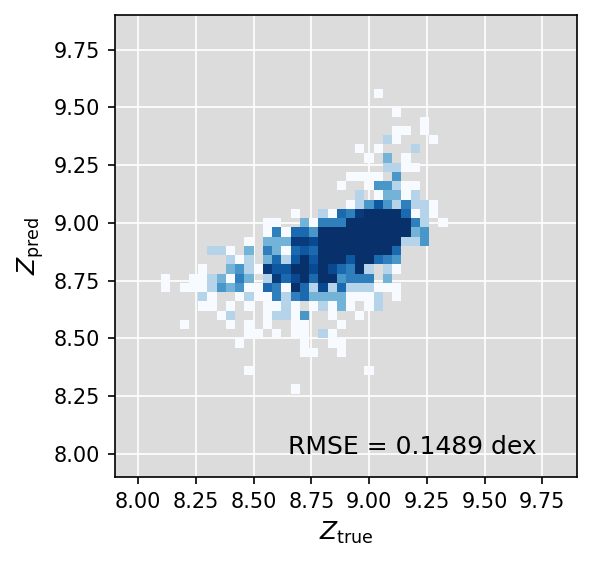

In [18]:
test_model(model, 0.0002754228771664202, 10)

## vg-16 cont.

SuggestedLRs(valley=0.0003311311302240938)


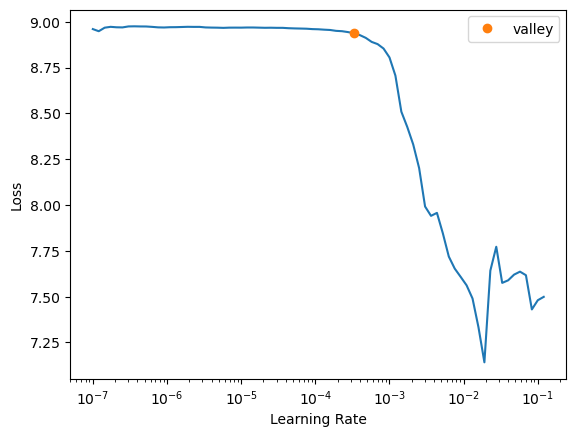

In [20]:
import torch.nn as nn

class Inception(nn.Module):
    def __init__(self):
        super(Inception, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(2),
            nn.Conv2d(64, 64, 5),
            nn.ReLU()
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out3 = self.conv3(x)
        out5 = self.conv5(x)
        return torch.cat([out1, out3, out5], dim=1)

model = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3,64,3),
            nn.ReLU(),
            Inception(),
            nn.Conv2d(192,64,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            Inception(),
            nn.Conv2d(192,64,1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*14*14, 4096),
            nn.ReLU(),
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128,1)          
)

find_lr(model)

epoch,train_loss,valid_loss,time
0,8.811039,8.295933,08:27
1,3.159020,0.181407,07:54
2,1.034853,0.235420,07:48
3,0.445330,0.278554,08:47
4,0.286237,0.174620,08:04
5,0.199165,0.139812,08:04
6,0.163191,0.148976,07:53
7,0.142236,0.129582,08:01
8,0.133988,0.128386,07:48
9,0.131031,0.127614,08:47


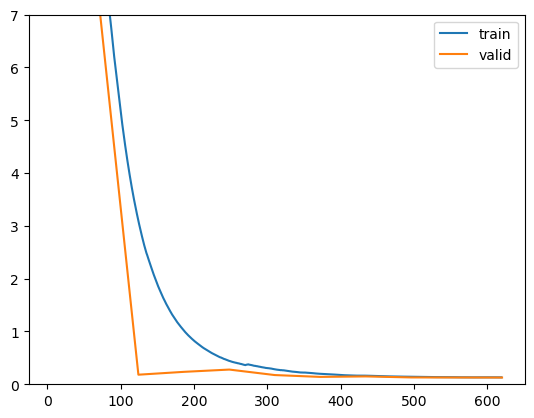

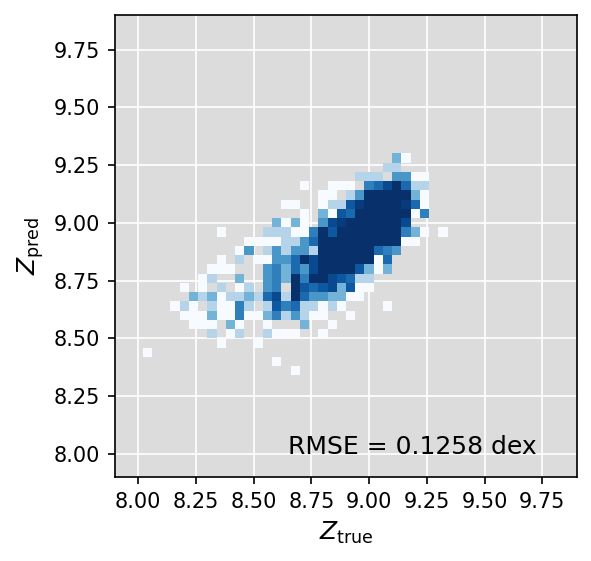

In [21]:
test_model(model, 0.0003311311302240938, 10)

## Multiple threads

SuggestedLRs(valley=0.00013182566908653826)


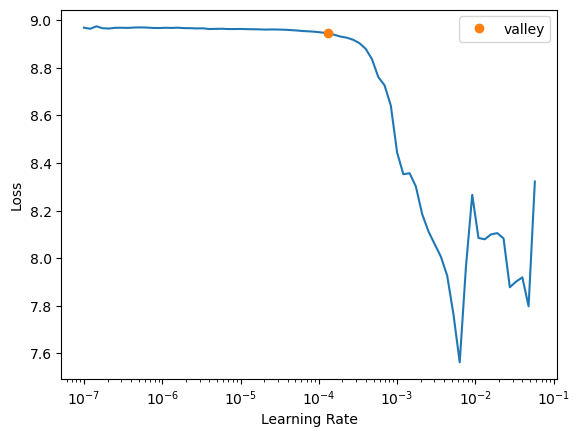

In [14]:
import torch.nn as nn

class Inception(nn.Module):
    def __init__(self):
        super(Inception, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.ReflectionPad2d(2),
            nn.Conv2d(64, 64, 5),
            nn.ReLU()
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out3 = self.conv3(x)
        out5 = self.conv5(x)
        return torch.cat([out1, out3, out5], dim=1)

model = nn.Sequential(
    nn.Conv2d(3,20,5),
    nn.ReLU(),
    nn.Conv2d(20,64,5),
    nn.ReLU(),    
    Inception(),
    nn.Conv2d(192,64,1),
    Inception(),
    nn.Conv2d(192,64,1),
    nn.MaxPool2d(2),
    Inception(),
    nn.Conv2d(192,64,1),
    Inception(),
    nn.Conv2d(192,64,1),
    nn.MaxPool2d(2),
    Inception(),
    nn.Conv2d(192,64,1),
    nn.Flatten(),
    nn.Linear(64*12*12, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

find_lr(model)

epoch,train_loss,valid_loss,time
0,8.917155,8.834804,08:00
1,5.702246,0.335762,07:25
2,1.684585,0.214630,07:28
3,0.633752,0.244824,07:28
4,0.340782,0.167902,07:24
5,0.234913,0.153833,07:15
6,0.197786,0.157386,07:18
7,0.173637,0.145516,07:30
8,0.155713,0.140696,07:33
9,0.145720,0.132831,07:32


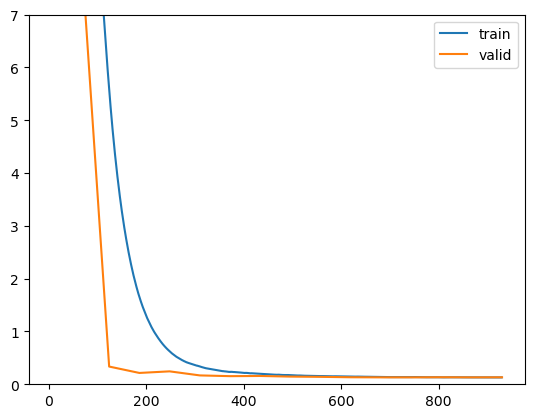

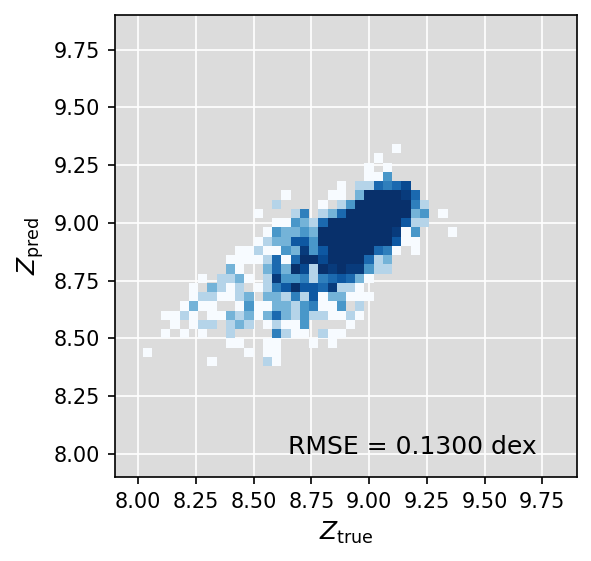

In [15]:
test_model(model, 0.00013182566908653826, 15)

## CNN based on VG-16 but with more layers

In [ ]:
model = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3,20,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(20,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.Flatten(),
            nn.Linear(64*14*14, 4096),
            nn.ReLU(),
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128,1)            
)

find_lr(model)

epoch,train_loss,valid_loss,time
0,7.839188,1.398058,01:51
1,2.111988,0.368339,01:48
2,0.737307,0.166726,01:46
3,0.336869,0.187388,01:51
4,0.216953,0.140140,01:47
5,0.166515,0.136074,01:46
6,0.147869,0.135275,01:52


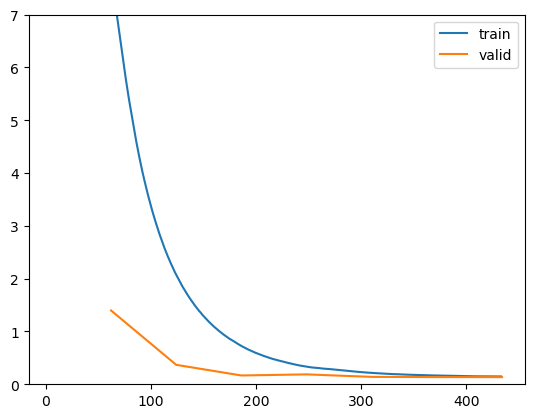

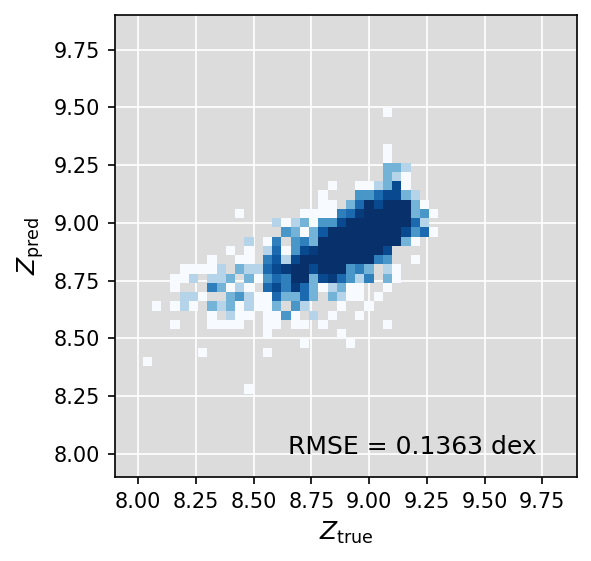

In [16]:
test_model(model, 0.0002754228771664202)

## CNN with 4 conv layers + padding

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3,20,5),
            nn.ReLU(),
            nn.Conv2d(20,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,64,3),
            nn.Flatten(),
            nn.Linear(64*24*24, 4096),
            nn.ReLU(),
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128,1)
        )

find_lr(model)

In [ ]:
test_model(model, )

## CNN single pooling, 3 fully connected

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3,20,5),
            nn.ReLU(),
            nn.Conv2d(20,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*24*24, 4096),
            nn.ReLU(),
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128,1)
        )

find_lr(model)

In [ ]:
test_model(model, )

## CNN double pooling

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3,20,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*12*12, 128),
            nn.ReLU(),
            nn.Linear(128,1)
        )

find_lr(model)

In [ ]:
test_model(model, )

## CNN single pooling

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3,20,5),
            nn.ReLU(),
            nn.Conv2d(20,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*24*24, 128),
            nn.ReLU(),
            nn.Linear(128,1)
        )

find_lr(model)

In [ ]:
test_model(model, )

## CNN no pooling

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3,20,5),
            nn.ReLU(),
            nn.Conv2d(20,64,5),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*48*48, 128),
            nn.ReLU(),
            nn.Linear(128,1)
        )

find_lr(model)

In [ ]:
test_model(model, )

## Xresnet (default)

SuggestedLRs(valley=0.0063095735386013985)


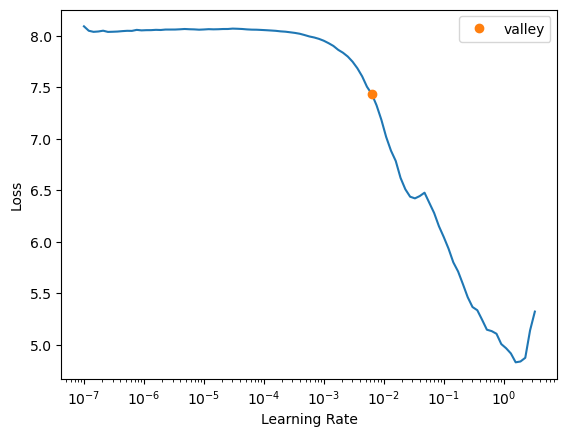

In [16]:
model = xresnet34(n_out=dls.c, sa=True)

find_lr(model)

epoch,train_loss,valid_loss,time
0,0.329552,0.181212,03:08
1,0.170420,0.135515,02:25
2,0.157787,0.120288,02:35
3,0.159556,0.119069,02:21
4,0.143877,0.114923,02:21
5,0.128724,0.116442,02:43
6,0.127510,0.110356,02:36
7,0.113821,0.109329,02:34
8,0.112319,0.109068,02:32
9,0.107306,0.109228,02:30


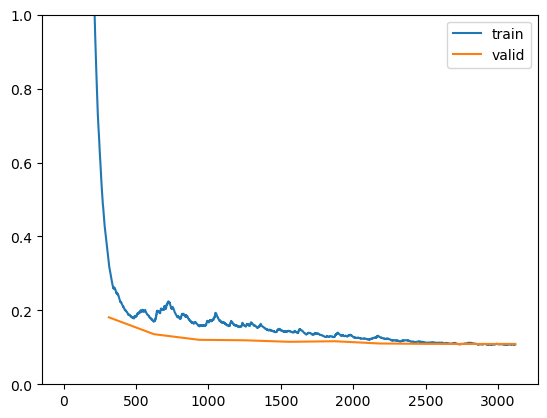

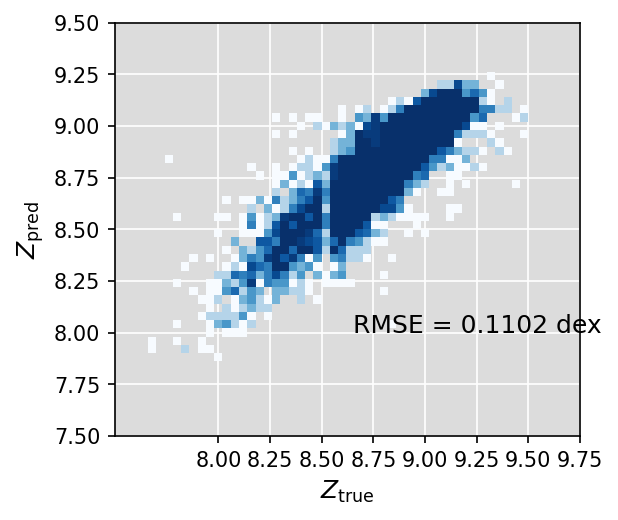

In [17]:
test_model(model, 0.0063095735386013985, 10)